## Download Data

Download dataset with `wget`

In [ ]:
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2024-11-02 11:29:20--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-11-02 11:29:21--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2024-11-02 11:29:21--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

In [ ]:
# !tar -xvf images.tar.gz
# !tar -xvf annotations.tar.gz

## Load Dataset

In [22]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [15]:
def readSplit(mode):
    split_filename = "test.txt" if mode == "test" else "trainval.txt"
    split_filepath = os.path.join("annotations", split_filename)
    with open(split_filepath, "r") as f:
        split_data = f.read().strip('\n').split('\n')

    file_names = [x.split(' ')[0] for x in split_data]
    if mode == "train":
        file_names = [x for i, x in enumerate(file_names) if i % 10 != 0]
    elif mode == "valid":
        file_names = [x for i, x in enumerate(file_names) if i % 10 == 0]
    
    return file_names


def loadDataset():
    train_dataset = readSplit("train")
    valid_dataset = readSplit("valid")
    test_dataset = readSplit("test")

    # It is a good practice to check datasets don`t intersects with each other
    assert set(test_dataset).isdisjoint(set(train_dataset))
    assert set(test_dataset).isdisjoint(set(valid_dataset))
    assert set(train_dataset).isdisjoint(set(valid_dataset))

    return train_dataset, valid_dataset, test_dataset

def preProcessMask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

def getImage(file_names, idx):
    file_name = file_names[idx]
    image_path = os.path.join("images", file_name + ".jpg")
    mask_path = os.path.join("annotations/trimaps", file_name + ".png")

    image = np.array(Image.open(image_path).convert("RGB"))
    triMap = np.array(Image.open(mask_path))
    mask = preProcessMask(triMap)

    image = np.array(Image.fromarray(image).resize((256, 256), Image.BILINEAR))
    mask = np.array(Image.fromarray(mask).resize((256, 256), Image.NEAREST))
    triMap = np.array(Image.fromarray(triMap).resize((256, 256), Image.NEAREST))

    image = np.moveaxis(image, -1, 0)
    mask = np.expand_dims(mask, 0)
    triMap = np.expand_dims(triMap, 0)

    return dict(image=image, mask=mask, triMap=triMap)


train_dataset, valid_dataset, test_dataset = loadDataset()
print("Train size:", len(train_dataset))
print("Valid size:", len(valid_dataset))
print("Test size:", len(test_dataset))

Train size: 3312
Valid size: 368
Test size: 3669


In [16]:
def plotSample(sample):
    plt.subplot(1,2,1)
    plt.imshow(sample["image"].transpose(1, 2, 0))
    plt.subplot(1,2,2)
    plt.imshow(sample["mask"].squeeze())
    plt.show()

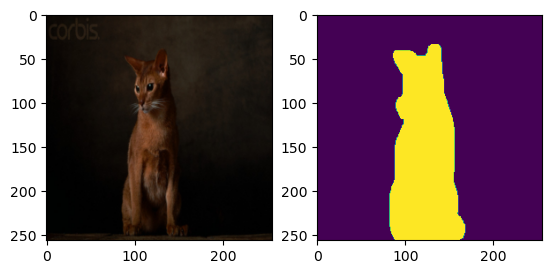

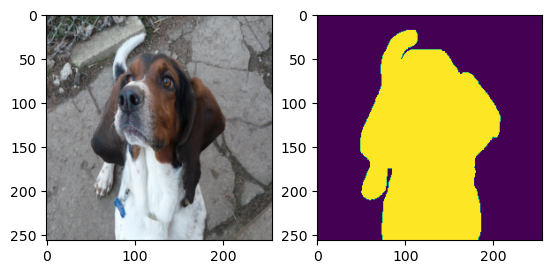

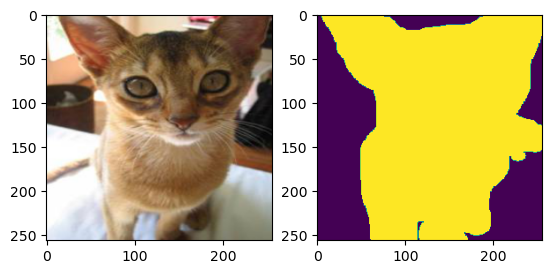

In [20]:
sample = getImage(train_dataset, 13)
plotSample(sample)

sample = getImage(valid_dataset, 16)
plotSample(sample)

sample = getImage(test_dataset, 19)
plotSample(sample)

## Build Model

In [ ]:
encoder_name = 'resnet34'
model = sm.FPN(
    encoder_name,
    classes=1
)
preprocess_input = sm.get_preprocessing(encoder_name)